### Entanglement distribution is a fundamental primitive for quantum networks, enabling protocols such as quantum teleportation, quantum key distribution, and distributed quantum computation. In practical quantum network architectures, entanglement must often be generated between distant nodes through intermediate stations, requiring protocols that combine quantum operations, measurements, and classical communication.

### This notebook investigates entanglement distribution using a quantum-walk–based protocol, with particular emphasis on the role of intermediate measurements and classical feed-forward. The protocol under study generates entanglement between two terminal nodes by performing quantum operations on intermediate qubits, followed by measurements that project the system into one of several Bell-state branches. The resulting entangled state depends on the measurement outcomes and can be analyzed  deterministically via feed-forward corrections.

In [1]:
#Importing necessary libraries
from qiskit import *
from qiskit.quantum_info import Statevector, partial_trace, DensityMatrix, state_fidelity 

# Construction of the circuit

## Creating the entangled pairs

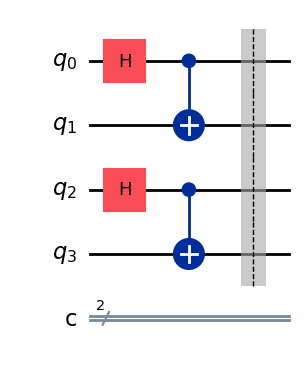

In [2]:
qc = QuantumCircuit(4,2)
qc.h(0)
qc.h(2)
qc.cx(0,1)
qc.cx(2,3)
qc.barrier()
qc.draw('mpl')

## Performing Discrete time Quantum Walk on the internal node's qubits

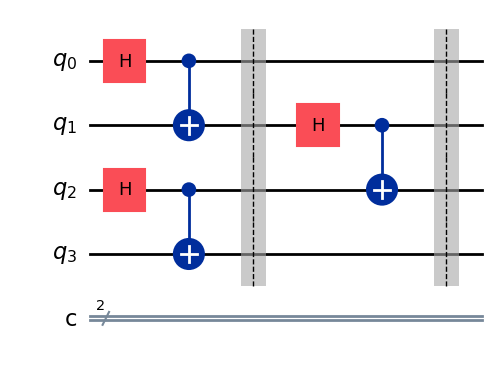

In [3]:
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.draw('mpl')

## Measurement on the internal node

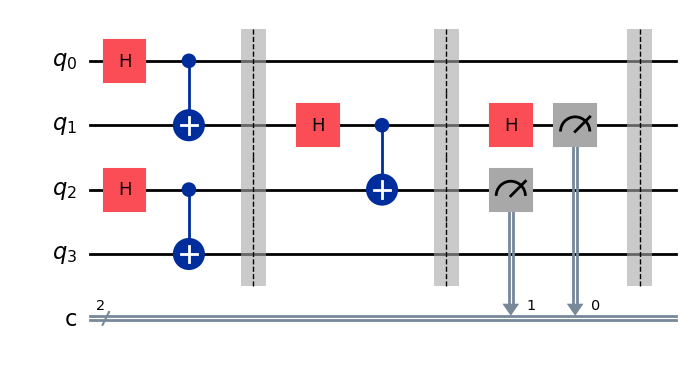

In [4]:
qc.h(1)
qc.measure(1,0)
qc.measure(2,1)
qc.barrier()
qc.draw('mpl')

## Local operation  on endnode

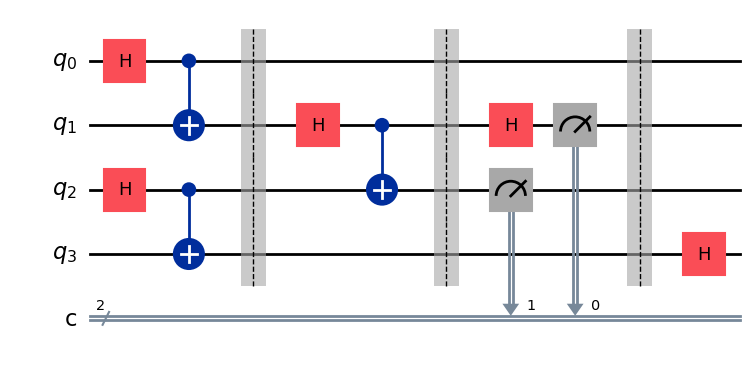

In [5]:
qc.h(3)
qc.draw('mpl')

# Feed Forward Method

### Feed-forward is a central mechanism in quantum network protocols, enabling deterministic entanglement distribution by combining quantum measurements with classical control. In entanglement-swapping–based schemes, measurements performed on intermediate nodes probabilistically project the end nodes into different Bell states. Without additional correction, this randomness prevents reliable use of entanglement as a network resource.

### This notebook focuses exclusively on the implementation and analysis of classical feed-forward in entanglement distribution protocols. Measurement outcomes obtained from intermediate qubits are used as classical information to conditionally apply local Pauli operations on the terminal nodes, thereby correcting the distributed state into a fixed target Bell state. This process eliminates the need for post-selection and ensures deterministic entanglement generation across all measurement branches.

### The implementation emphasizes protocol-level correctness rather than hardware execution. Simulations are performed using the density-matrix formalism to support mid-circuit measurements and classical control, which are essential for modeling feed-forward. The resulting end-node states are analyzed via reduced density matrices and Bell-state fidelity, demonstrating the effectiveness of feed-forward in unifying probabilistic measurement outcomes into a consistent entanglement resource.

In [6]:
qc_ff = qc.copy()

## Applying Feed-Forward Logic

In [7]:
# If c[1] == 1 → apply X
with qc_ff.if_test((qc_ff.clbits[1], 1)):
    qc_ff.z(3)

# If c[0] == 1 → apply Z
with qc_ff.if_test((qc_ff.clbits[0], 1)):
    qc_ff.x(3)


In [8]:
from qiskit_aer import AerSimulator

sim = AerSimulator(method="density_matrix")

qc_ff.save_density_matrix()
result = sim.run(qc_ff, shots=1).result()

rho_full = result.data(0)["density_matrix"]

from qiskit.quantum_info import partial_trace
rho_end1 = partial_trace(rho_full, [1,2])


In [9]:
def bell_state(label):
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    if label == "phi-":
        qc.z(1)
    elif label == "psi+":
        qc.x(1)
    elif label == "psi-":
        qc.x(1)
        qc.z(1)
    return Statevector.from_instruction(qc)

bells = {
    "phi+": bell_state("phi+"),
    "phi-": bell_state("phi-"),
    "psi+": bell_state("psi+"),
    "psi-": bell_state("psi-")
}

## Calculating Fidelity (Ideal Condition

In [10]:
for name, bell in bells.items():
    print(name, state_fidelity(rho_end1, bell))

phi+ 0.9999999999999998
phi- 0.0
psi+ -1.2325951644078307e-32
psi- 0.0


In [11]:
# To confirm that the non zero psi plus fidelity is not physical error
import numpy as np
print("Trace:", np.trace(rho_end1.data))
print("Purity:", np.trace(rho_end1.data @ rho_end1.data))

Trace: (1+0j)
Purity: (1+1.1161943132134687e-65j)


## Building the decoherence-only noise model

In [12]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise import amplitude_damping_error, phase_damping_error

gamma = 0.02   # T1-related
lam   = 0.03   # T2-related

noise_model = NoiseModel()

single_qubit_noise = (
    amplitude_damping_error(gamma)
    .compose(phase_damping_error(lam))
)

# Apply to 1-qubit gates
noise_model.add_all_qubit_quantum_error(
    single_qubit_noise, ['h']
)

# Apply independently to each qubit in CX
noise_model.add_all_qubit_quantum_error(
    single_qubit_noise.tensor(single_qubit_noise), ['cx']
)


## Using the existing feed-forward circuit

In [13]:
qc_noisy = qc_ff.copy()
qc_noisy.save_density_matrix(label="rho_final")


## Simulate with density matrix + noise

In [14]:
sim = AerSimulator(
    method="density_matrix",
    noise_model=noise_model
)

result = sim.run(qc_noisy).result()
data = result.results[0].data.to_dict()
rho_full1 = data["rho_final"]



## Extract the end-node state

In [15]:
from qiskit.quantum_info import partial_trace

rho_end = partial_trace(rho_full1, [1, 2])


In [16]:
for name, bell in bells.items():
    print(name, state_fidelity(rho_end, bell))

phi+ 0.8535453371482641
phi- 0.05373742262859754
psi+ 0.06360520560150489
psi- 0.029112034621633868


In [17]:
import numpy as np
purity = np.trace(rho_end.data @ rho_end.data)
print("Purity:", purity)


Purity: (0.7370773837680297+3.6111186457260672e-34j)


## The reduced end-node state exhibits a purity of approximately 0.74, confirming partial mixedness induced by T₁/T₂ decoherence while retaining significant entanglement.

##  Robustness under decoherence

### Having characterized the end-node state for a fixed noise strength, we now study how the quality of distributed entanglement degrades as decoherence increases. In particular, we track the Bell-state fidelity and purity as functions of the noise strength, providing a quantitative measure of robustness of the feed-forward protocol.


# Visualization

### For simplicity, a symmetric decoherence model with equal amplitude and phase damping strengths (γ = λ) was considered, corresponding to a special case where relaxation and dephasing contribute comparably to entanglement degradation.

## Prepare ideal Bell state

In [18]:

bell_circ = QuantumCircuit(2)
bell_circ.h(0)
bell_circ.cx(0, 1)
bell1 = Statevector.from_instruction(bell_circ)


## Sweep noise strength

In [19]:
ps = np.linspace(0.0, 0.1, 12)   # noise strength
fidelities = []
purities = []


## Main simulation loop (FEED-FORWARD + NOISE)

In [20]:
for p in ps:

    # --- Noise model ---
    noise_model = NoiseModel()
    single_noise = (
        amplitude_damping_error(p)
        .compose(phase_damping_error(p))
    )

    noise_model.add_all_qubit_quantum_error(single_noise, ['h'])
    noise_model.add_all_qubit_quantum_error(
        single_noise.tensor(single_noise), ['cx']
    )

    # --- Simulator ---
    sim = AerSimulator(
        method="density_matrix",
        noise_model=noise_model
    )

    # --- Run circuit ---
    qc_run = qc_ff.copy()
    qc_run.save_density_matrix(label="rho")

    result = sim.run(qc_run).result()
    rho_full2 = result.results[0].data.to_dict()["rho"]

    # --- Reduced state ---
    rho_end2 = partial_trace(rho_full2, [1, 2])

    # --- Metrics ---
    fidelities.append(state_fidelity(rho_end2, bell1))
    purities.append(np.real(np.trace(rho_end2.data @ rho_end2.data)))


## Plot results

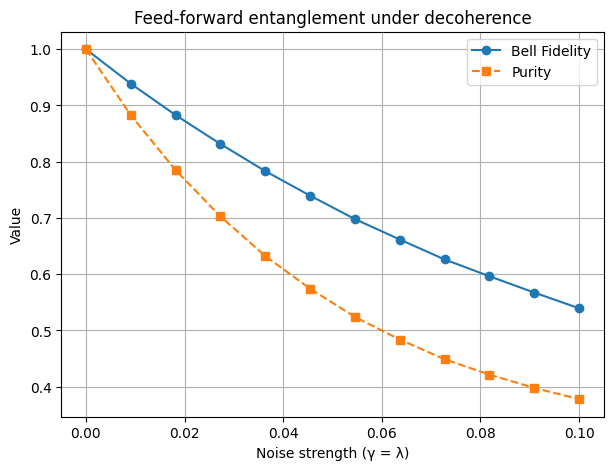

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(ps, fidelities, 'o-', label="Bell Fidelity")
plt.plot(ps, purities, 's--', label="Purity")

plt.xlabel("Noise strength (γ = λ)")
plt.ylabel("Value")
plt.title("Feed-forward entanglement under decoherence")
plt.legend()
plt.grid(True)
plt.show()


## Distinguishing relaxation and dephasing effects

### To isolate the physical origin of entanglement degradation, we now separately analyze the impact of amplitude damping (T₁ processes) and phase damping (T₂ processes). This allows us to distinguish loss-driven decoherence from pure dephasing effects in the feed-forward entanglement distribution protocol.


In [22]:
ps = np.linspace(0.0, 0.1, 12)

fid_T1, pur_T1 = [], []
fid_T2, pur_T2 = [], []


In [23]:
for p in ps:

    # -------- T1-only (amplitude damping) --------
    noise_T1 = NoiseModel()
    noise_T1.add_all_qubit_quantum_error(
        amplitude_damping_error(p), ['h']
    )
    noise_T1.add_all_qubit_quantum_error(
        amplitude_damping_error(p).tensor(amplitude_damping_error(p)), ['cx']
    )

    sim_T1 = AerSimulator(method="density_matrix", noise_model=noise_T1)

    qc_run = qc_ff.copy()
    qc_run.save_density_matrix(label="rho")

    result = sim_T1.run(qc_run).result()
    rho_full = result.results[0].data.to_dict()["rho"]
    rho_end = partial_trace(rho_full, [1, 2])

    fid_T1.append(state_fidelity(rho_end, bell1))
    pur_T1.append(np.real(np.trace(rho_end.data @ rho_end.data)))

    # -------- T2-only (phase damping) --------
    noise_T2 = NoiseModel()
    noise_T2.add_all_qubit_quantum_error(
        phase_damping_error(p), ['h']
    )
    noise_T2.add_all_qubit_quantum_error(
        phase_damping_error(p).tensor(phase_damping_error(p)), ['cx']
    )

    sim_T2 = AerSimulator(method="density_matrix", noise_model=noise_T2)

    qc_run = qc_ff.copy()
    qc_run.save_density_matrix(label="rho")

    result = sim_T2.run(qc_run).result()
    rho_full = result.results[0].data.to_dict()["rho"]
    rho_end = partial_trace(rho_full, [1, 2])

    fid_T2.append(state_fidelity(rho_end, bell1))
    pur_T2.append(np.real(np.trace(rho_end.data @ rho_end.data)))


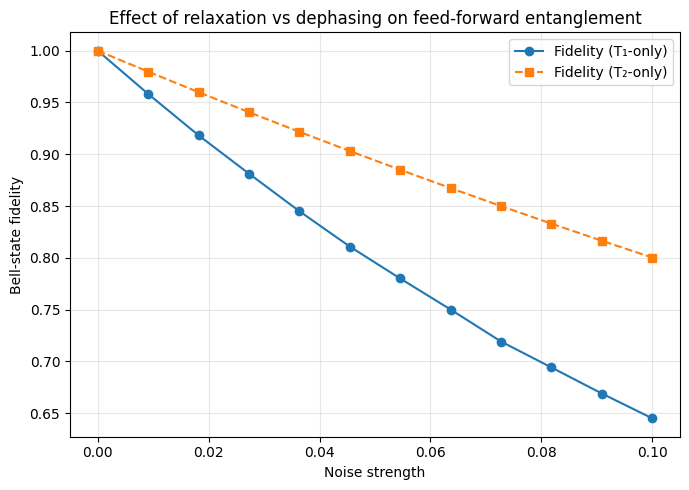

In [24]:
plt.figure(figsize=(7,5))

plt.plot(ps, fid_T1, 'o-', label="Fidelity (T₁-only)")
plt.plot(ps, fid_T2, 's--', label="Fidelity (T₂-only)")

plt.xlabel("Noise strength")
plt.ylabel("Bell-state fidelity")
plt.title("Effect of relaxation vs dephasing on feed-forward entanglement")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Bell-state fidelity of the end-node state as a function of physical time for T₁-only and T₂-only decoherence. The mapping from noise strength to time is obtained using exponential decay models. Relaxation-induced population loss leads to faster degradation compared to pure dephasing.

In [25]:
import numpy as np

T1_us = 100.0   # microseconds
T2_us = 80.0    # microseconds

time_T1 = -T1_us * np.log(1 - ps)
time_T2 = -T2_us * np.log(1 - ps)


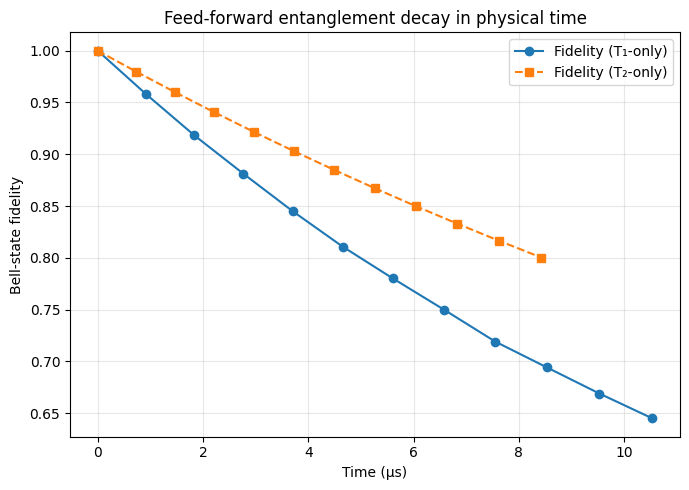

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

plt.plot(time_T1, fid_T1, 'o-', label="Fidelity (T₁-only)")
plt.plot(time_T2, fid_T2, 's--', label="Fidelity (T₂-only)")

plt.xlabel("Time (μs)")
plt.ylabel("Bell-state fidelity")
plt.title("Feed-forward entanglement decay in physical time")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Mapping the noise parameters to physical time reveals the temporal robustness of feed-forward entanglement distribution. While classical feed-forward removes measurement-induced randomness, fidelity decay is governed by intrinsic decoherence times. Relaxation processes (T₁) lead to faster entanglement degradation due to irreversible population loss, whereas pure dephasing (T₂) preserves populations and allows entanglement to persist over longer timescales.

## Treat the coin operator of the quantum walk as a trainable variational circuit, and optimize its parameters to maximize end-node entanglement fidelity (or related network objectives) under realistic noise.

## Varitional coin

In [27]:
def variational_coin(theta):
    """Single-qubit variational coin"""
    qc = QuantumCircuit(1)
    qc.rz(theta[0], 0)
    qc.ry(theta[1], 0)
    qc.rz(theta[2], 0)
    return qc


In [28]:
def build_noisy_circuit_with_coin(theta):
    qc_ff_template = QuantumCircuit(4,2)
    qc_ff_template.h(0)
    qc_ff_template.h(2)
    qc_ff_template.cx(0,1)
    qc_ff_template.cx(2,3)
    qc_ff_template.barrier()
    # Replace fixed coin with variational coin
    coin = variational_coin(theta)
    qc_ff_template.compose(coin, qubits=[1], inplace=True)  # coin qubit = 1
    qc_ff_template.cx(1,2)
    qc_ff_template.barrier()
    qc_ff_template.h(1)
    qc_ff_template.measure(1,0)
    qc_ff_template.measure(2,1)
    qc_ff_template.barrier()
    qc_ff_template.h(3)

    # Save density matrix
    qc_ff_template.save_density_matrix(label="rho")

    return qc_ff_template


In [29]:
from qiskit.quantum_info import partial_trace, state_fidelity

def loss_function(theta):
    qc_run = build_noisy_circuit_with_coin(theta)

    result = sim.run(qc_run).result()
    rho_full = result.results[0].data.to_dict()["rho"]

    # Trace out intermediate qubits
    rho_end = partial_trace(rho_full, [1, 2])

    fidelity = state_fidelity(rho_end, bell1)
    return 1 - fidelity


In [30]:
from scipy.optimize import minimize

theta_init = np.random.uniform(0, 2*np.pi, 3)

res = minimize(
    loss_function,
    theta_init,
    method="COBYLA",
    options={"maxiter": 50}
)

theta_opt = res.x

print("Optimal θ:", theta_opt)
print("Final fidelity:", 1 - res.fun)


Optimal θ: [2.22668723 5.91042628 5.74150259]
Final fidelity: 0.25769979950587907


In [31]:
# Approximate Hadamard coin
theta_h = np.array([0, np.pi/2, 0])

fid_fixed = 1 - loss_function(theta_h)
fid_learned = 1 - loss_function(theta_opt)

print("Fixed coin fidelity:", fid_fixed)
print("Learned coin fidelity:", fid_learned)


Fixed coin fidelity: 0.26145766829981265
Learned coin fidelity: 0.25325849358506036


In [32]:
theta_h = np.array([0, np.pi/2, 0])
print("Hadamard-equivalent fidelity:", 1 - loss_function(theta_h))


Hadamard-equivalent fidelity: 0.25985060349722355
